In [4]:
import functools
import math
import numpy as np
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
sns.set_style("white")

import matplotlib as plt
plt.rcParams['figure.figsize'] = (8,6)

from IPython.display import display

### Load Database

In [5]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [180]:
db = DB('earthfury-alliance', timerange=14)

In [181]:
item = 2840 # copper bar

### Percentile Functions

In [182]:
def pctBelowValue(series, value):
    return stats.percentileofscore(series, value)/100

def pctAboveValue(series, value):
    return 1-stats.percentileofscore(series, value)/100

def valueAtPctile(series, pctile):
    return series.quantile(pctile)
    

### Daily Rollups

In [183]:
def dailyMax(item, column='minBuyout'):
    # use 90 pctile instead of max() to avoid outliers
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.9)

def dailyMin(item, column='minBuyout'):
    # use 10 pctile instead of min() to avoid outliers
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.1)

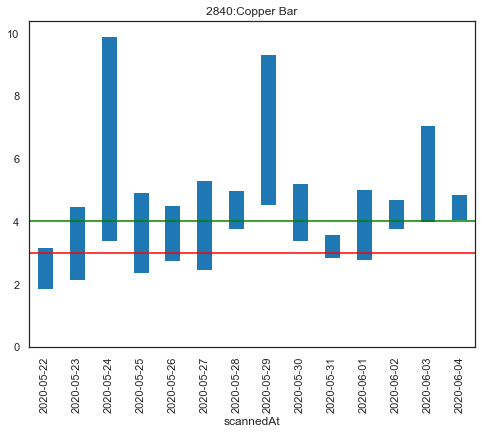

In [184]:
def plotDailyRange(item, buyAt=None, sellAt=None):
    title = f'{item}:{db.get_name(item)}'
        
    # create bars
    _, ax = plt.subplots()
    dailyMax(item).plot(kind='bar', x='scannedAt', y='minBuyout', title=title, ax=ax)
    dailyMin(item).plot(kind='bar', x='scannedAt', y='minBuyout', color='w', ax=ax)
    
    # add buy lines if passed
    if buyAt and sellAt:
        ax.axhline(y=buyAt, color='red')
        ax.axhline(y=sellAt, color='green')

    
plotDailyRange(item, 3, 4)

### Analysis

In [207]:
def postcost_at_salerate(item, salerate):
    if salerate == 0:
        return 0
    vp = db.get_vendorprice(item) # double check this value is working correctly using in game reference 
    return (1-salerate) / salerate * (.6*vp)

def iterPrice(item):
    # iterate from min price to max price in .01 percentile steps
    for pctile in np.arange(0, 1, .01):
        yield db.get_df_hourly(item)['minBuyout'].quantile(pctile)

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,flipRate,timeValue,roi
64,2840,Copper Bar,4.4872,0.857143,0.01,4.26284,3.219077,0.601852,1.258123,0.515873,0.649032,0.200996


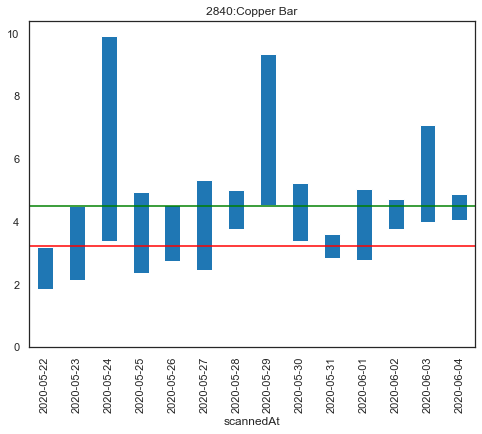

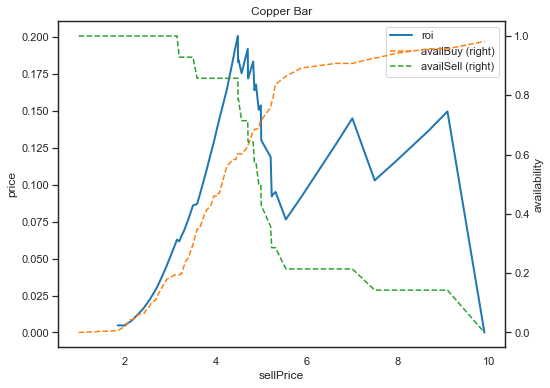

In [275]:
def analysis(item, show=False):
    columns = ['sellPrice', 'availSell', 'postCost', 'maxBuy', 'meanBuy', 'availBuy', 'value', 'timeValue', 'roi']
    data = []
    for sellPrice in iterPrice(item):
        availSell = pctAboveValue(dailyMax(item), sellPrice) # use dailyMax series due to selling pattern

        # expected posting cost based on avail sell
        postCost = postcost_at_salerate(item, availSell)

        # buying values
        maxBuy   = sellPrice * .95
        meanBuy  = db.get_df_hourly(item).query('minBuyout <= @maxBuy')['minBuyout'].mean()
        availBuy = pctBelowValue(db.get_df_hourly(item)['minBuyout'], maxBuy) # use hourly series due to buying pattern        

        # profit
        value = sellPrice - meanBuy - postCost
        timeValue = value * availSell * availBuy
        roi = timeValue / (meanBuy + postCost)        
        
        # load into data
        data.append({
            'item_id'  :item,
            'name'     :db.get_name(item),
            'sellPrice':sellPrice,
            'availSell':availSell, 
            'postCost' :postCost,
            'maxBuy'   :maxBuy, 
            'meanBuy'  :meanBuy,
            'availBuy' :availBuy,
            'value'    :value, 
            'flipRate' :availSell * availBuy,
            'timeValue':timeValue, 
            'roi'      :roi,        
        })
    
    # no data caused by 100% exclusion
    if data == []:
        print(f'{item}:{db.get_name(item)} excluded')
        return

    # data frame for analysis
    df = pd.DataFrame(data)    
    best = df.loc[df['roi'] == df['roi'].max()]

    if show:
        # show best record
        display(best)
        
        # plot daily range and buy/sell lines
        plotDailyRange(item, best.iloc[0]['meanBuy'], best.iloc[0]['sellPrice'])
        
        # plot analysis curve
        _, ax = plt.subplots()
        df.plot(x='sellPrice', y=['roi'], title=db.get_name(item), linewidth=2, ax=ax)
        df.plot(x='sellPrice', y=['availBuy', 'availSell'], style='--', secondary_y=True, ax=ax)
        ax.set_ylabel('price')
        ax.right_ax.set_ylabel('availability')
        return
    return best.to_dict('r')[0]
    
analysis(item, show=True)

### Full Run

In [234]:
%run ITEMS.ipynb


loaded
  herbs       : 30 items
  cloth       : 12 items
  mining      : 27 items
  enchant     : 24 items
  skinning    : 11 items
  meat        : 27 items
  consumables : 44 items
  bags        : 38 items
  eng         : 53 items
  ALL         : 266 items
  CHOICE      : 70 items (quantity>100 and sellPrice>2.5s)



In [277]:
%%time

# a bunch of printing and error catching, to simply map(fn, list_of_items)
def run_analysis(list_of_items, fn):
    print(f'running for {len(list_of_items)} items')    
    results = []    
    for i, item in enumerate(list_of_items):       
        # catch no data errors with try/except
        try:
            results.append(fn(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')
        # print progress
        if i%10 ==0: print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results).round(2)

df = run_analysis(CHOICE, analysis)

running for 70 items
 ...0 done
 ...10 done
 ...20 done
 ...30 done
 ...40 done
 ...50 done
 ...60 done
COMPLETE
Wall time: 31.6 s


### Inspect Results

In [276]:
df.sort_values(by='roi')

,item_id,name,sellPrice,availSell,postCost,maxBuy,meanBuy,availBuy,value,timeValue,roi,fliprate,flipRate
53,13457,Greater Fire Protection Potion,617.66,0.71,1.80,586.78,566.61,0.21,49.26,7.38,0.01,0.1491,0.1491
37,12359,Thorium Bar,19.98,0.79,0.98,18.98,17.18,0.40,1.82,0.58,0.03,0.3160,0.3160
3,8845,Ghost Mushroom,145.00,0.14,13.50,137.75,107.62,0.97,23.88,3.32,0.03,0.1358,0.1358
21,14047,Runecloth,6.51,1.00,0.00,6.18,5.72,0.18,0.79,0.14,0.03,0.1800,0.1800
20,4338,Mageweave Cloth,3.96,1.00,0.00,3.76,3.62,0.27,0.34,0.09,0.03,0.2700,0.2700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,10978,Small Glimmering Shard,17.60,0.07,0.00,16.72,2.50,0.99,15.10,1.06,0.43,0.0693,0.0693
8,2450,Briarthorn,9.40,0.71,0.06,8.93,5.17,0.79,4.17,2.37,0.45,0.5609,0.5609
15,2449,Earthroot,2.98,0.29,0.30,2.83,0.65,0.90,2.02,0.52,0.55,0.2610,0.2610
39,11137,Vision Dust,14.30,0.57,0.00,13.58,5.49,0.82,8.81,4.12,0.75,0.4674,0.4674


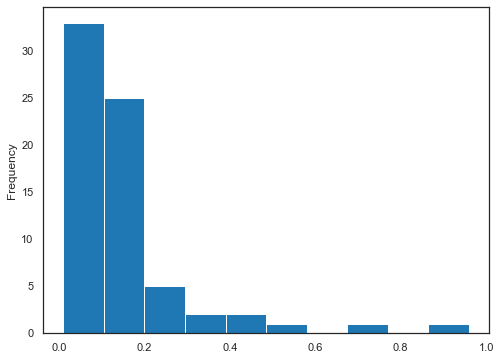

In [238]:
df['roi'].plot(kind='hist')

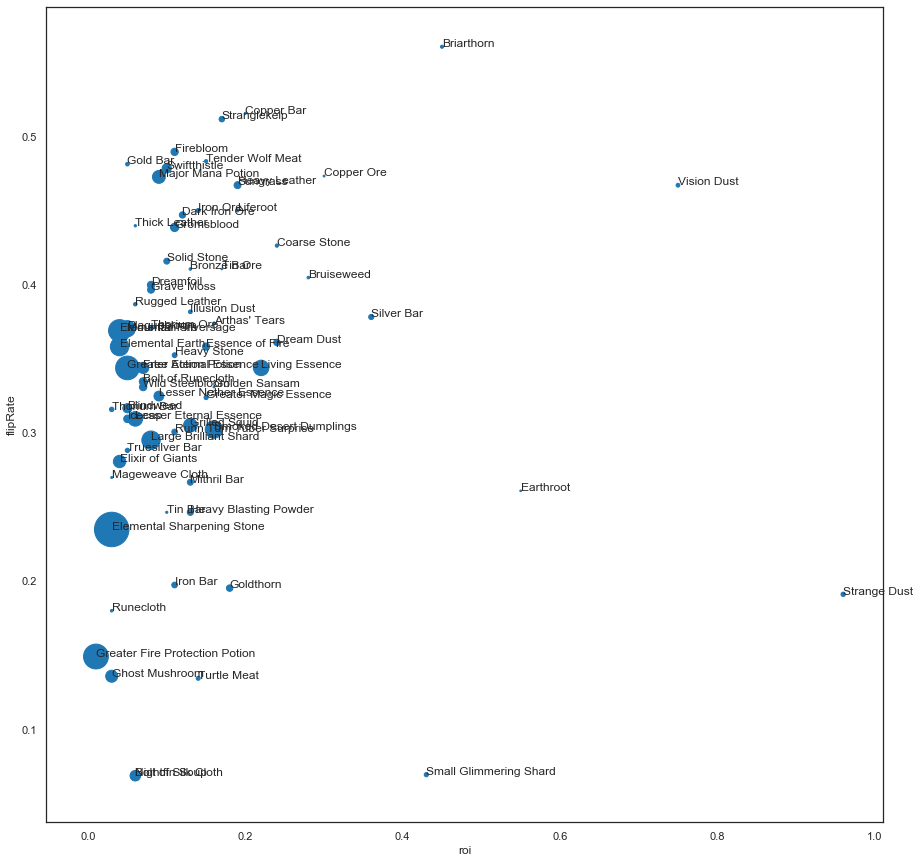

In [273]:
df['flipRate'] = df['availSell'] * df['availBuy']

x = 'roi'
y = 'flipRate'
ax = df.plot(kind='scatter', x=x, y=y, s=df['sellPrice'], figsize=(15,15))


for _, r in df.iterrows():
    ax.text(r[x], r[y], r['name'])
    

### Export

In [278]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe) --> expects df with specific columns
                          name         - required, string
                          item_id      - required, integer
                          buy_price    - required, integer in copper
                          min_price    - required, integer in copper 
                          normal_price - required, integer in copper
                          max_price    - required, integer in copper
                          restock      - optional, default 20
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [279]:
e = df.copy()
# format for export (note, 100x to scale integer copper)
e['buy_price']    = 100 * e['sellPrice'] * .95 
e['min_price']    = 100 * e['sellPrice']
e['normal_price'] = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
e['max_price']    = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
e = e.astype({'buy_price':int, 'min_price':int, 'normal_price':int, 'max_price':int})

In [280]:
# restock=75 if item price is less than 1g, else stack_size=30
e['restock'] = e['sellPrice'].apply(lambda x: 75 if x < 100 else 30)

# stack_size=10 if item price is less than 1g, else stack_size=5
e['stack_size'] = e['sellPrice'].apply(lambda x: 10 if x < 100 else 5)

In [281]:
EXPORT(e)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^SArthas' Tears^T^SaboveMax^SmaxPrice^SnormalPrice^S843^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S843^SignoreLowDuration^N0^SstackSize^N10^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S767^SkeepQtySources^T^t^Sblacklist^S^t^SPlaguebloom^T^SaboveMax^SmaxPrice^SnormalPrice^S28468^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S28468^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S25880^SkeepQtySources^T^t^Sblacklist^S^t^SMountain Silversage^T^SaboveMax^SmaxPrice^SnormalPrice^S16182^Sduration^N3^Smatch